In [1]:
# ============================================================================
# CELL 1: Import Required Libraries
# ============================================================================


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)




In [2]:
# ============================================================================
# CELL 2: Upload and Extract Dataset
# ============================================================================


from google.colab import files

# Upload the zip file
print("/content/online+retail.zip")
uploaded = files.upload()

# Extract the zip file
zip_filename = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('data')
    print(f"\n✓ Files extracted successfully!")
    print(f"Extracted files: {zip_ref.namelist()}")


/content/online+retail.zip


Saving online+retail.zip to online+retail (1).zip

✓ Files extracted successfully!
Extracted files: ['Online Retail.xlsx']


In [3]:
# ============================================================================
# CELL 3: Load and Explore the Dataset
# ============================================================================


# Load the dataset (the file is typically named 'Online Retail.xlsx')
df = pd.read_excel('data/Online Retail.xlsx')

print("Dataset Shape:", df.shape)
print("\n" + "="*80)
print("First 5 rows:")
print(df.head())
print("\n" + "="*80)
print("Dataset Info:")
print(df.info())
print("\n" + "="*80)
print("Statistical Summary:")
print(df.describe())
print("\n" + "="*80)
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*80)
print("Unique Customers:", df['CustomerID'].nunique())


Dataset Shape: (541909, 8)

First 5 rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-

In [4]:
# ============================================================================
# CELL 4: Data Preprocessing - Cleaning
# ============================================================================
"""
Clean the data by handling missing values, removing duplicates,
and filtering invalid records
"""

print("Original dataset shape:", df.shape)

# Remove rows with missing CustomerID (can't segment without customer info)
df = df.dropna(subset=['CustomerID'])
print(f"After removing missing CustomerID: {df.shape}")

# Remove rows with missing Description
df = df.dropna(subset=['Description'])
print(f"After removing missing Description: {df.shape}")

# Remove cancelled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
print(f"After removing cancelled orders: {df.shape}")

# Remove records with negative or zero quantity
df = df[df['Quantity'] > 0]
print(f"After removing invalid quantity: {df.shape}")

# Remove records with negative or zero price
df = df[df['UnitPrice'] > 0]
print(f"After removing invalid price: {df.shape}")

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Convert CustomerID to integer
df['CustomerID'] = df['CustomerID'].astype(int)

print("\n✓ Data cleaning completed!")
print(f"Final dataset shape: {df.shape}")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")



Original dataset shape: (541909, 8)
After removing missing CustomerID: (406829, 8)
After removing missing Description: (406829, 8)
After removing cancelled orders: (397924, 8)
After removing invalid quantity: (397924, 8)
After removing invalid price: (397884, 8)

✓ Data cleaning completed!
Final dataset shape: (397884, 9)
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [5]:
# ============================================================================
# CELL 5: RFM (Recency, Frequency, Monetary) Feature Engineering
# ============================================================================
"""
Create RFM features for customer segmentation:
- Recency: Days since last purchase
- Frequency: Number of purchases
- Monetary: Total amount spent
"""

# Set a reference date (1 day after the last transaction date)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Reference Date for Recency calculation: {reference_date}")

# Calculate RFM metrics for each customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency (unique invoices)
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("\nRFM DataFrame shape:", rfm.shape)
print("\n" + "="*80)
print("RFM Summary Statistics:")
print(rfm.describe())
print("\n" + "="*80)
print("Sample RFM data:")
print(rfm.head(10))

# Check for any invalid values
print("\n" + "="*80)
print("Missing values in RFM:")
print(rfm.isnull().sum())


Reference Date for Recency calculation: 2011-12-10 12:50:00

RFM DataFrame shape: (4338, 4)

RFM Summary Statistics:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000

Sample RFM data:
   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40
5       12352       36          8   2506.04
6       

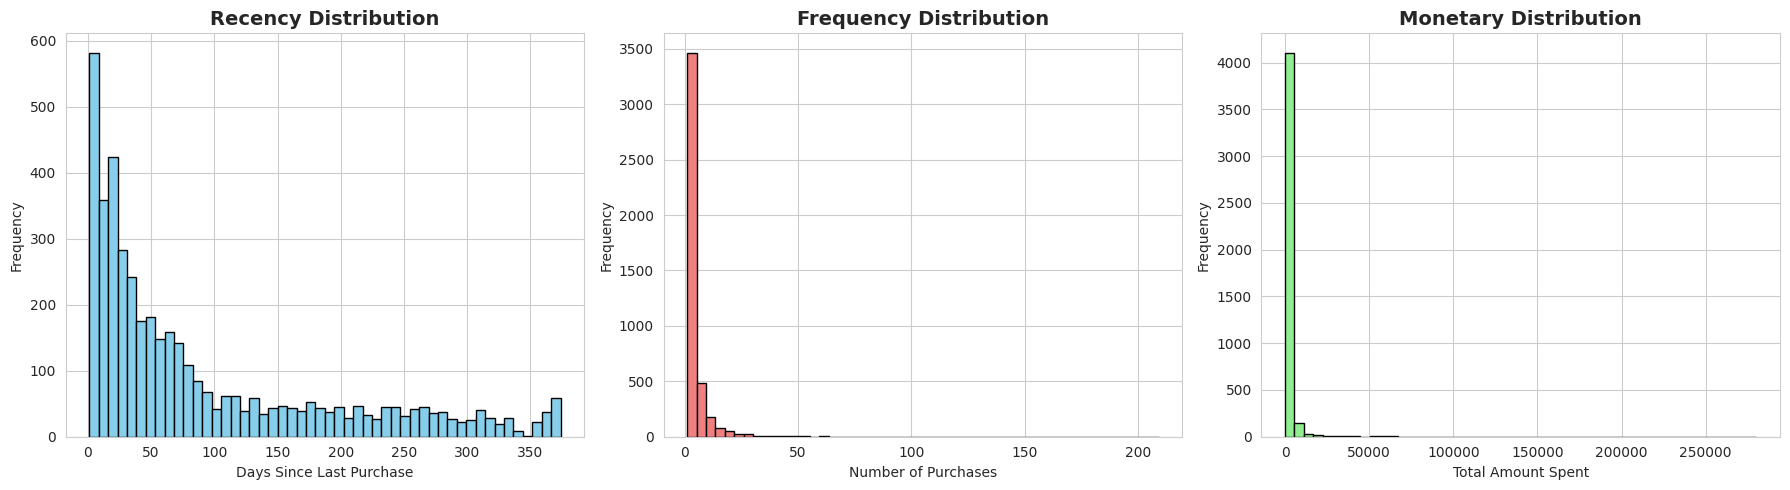


RFM shape before outlier removal: (4338, 4)
RFM shape after outlier removal: (4057, 4)
Removed 281 outlier customers


In [6]:
# ============================================================================
# CELL 6: Handle Outliers and Data Distribution
# ============================================================================
"""
Here,
I, Visualize distributions and handle extreme outliers that might
affect clustering results
"""

# Visualize distributions before outlier removal
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(rfm['Recency'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Recency Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days Since Last Purchase')
axes[0].set_ylabel('Frequency')

axes[1].hist(rfm['Frequency'], bins=50, color='lightcoral', edgecolor='black')
axes[1].set_title('Frequency Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Purchases')
axes[1].set_ylabel('Frequency')

axes[2].hist(rfm['Monetary'], bins=50, color='lightgreen', edgecolor='black')
axes[2].set_title('Monetary Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Total Amount Spent')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Remove extreme outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

print(f"\nRFM shape before outlier removal: {rfm.shape}")

# Remove outliers for each feature
rfm_clean = rfm.copy()
for col in ['Recency', 'Frequency', 'Monetary']:
    rfm_clean = remove_outliers_iqr(rfm_clean, col)

print(f"RFM shape after outlier removal: {rfm_clean.shape}")
print(f"Removed {len(rfm) - len(rfm_clean)} outlier customers")

Scaled RFM Features:
     Recency  Frequency  Monetary
1  -0.945527   1.416255  3.178275
2  -0.222360   0.326601  0.757583
3  -0.777119  -0.763053  0.719347
4   2.105643  -0.763053 -0.651659
5  -0.608710   1.779473  1.440412
6   1.055565  -0.763053 -0.888067
7   1.332944  -0.763053  0.066044
8   1.154629  -0.763053 -0.531239
9  -0.737493  -0.036617  1.734613
11 -0.945527  -0.399835  0.151456

Scaled Features Statistics:
            Recency     Frequency      Monetary
count  4.057000e+03  4.057000e+03  4.057000e+03
mean  -8.100222e-17 -1.050840e-17  1.856483e-16
std    1.000123e+00  1.000123e+00  1.000123e+00
min   -9.554338e-01 -7.630534e-01 -9.701938e-01
25%   -7.573058e-01 -7.630534e-01 -6.915419e-01
50%   -4.006755e-01 -3.998353e-01 -3.809643e-01
75%    5.602450e-01  3.266008e-01  3.429719e-01
max    2.739652e+00  5.048436e+00  3.992950e+00


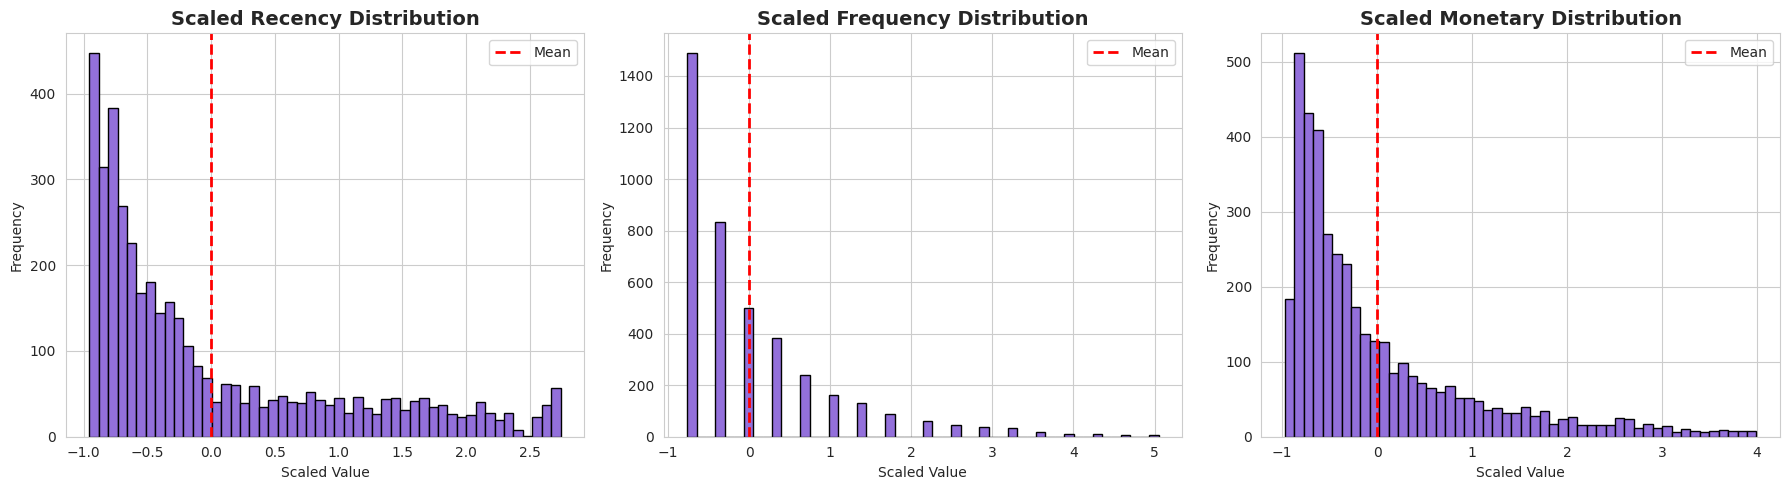


✓ Feature scaling completed!


In [7]:
# ============================================================================
# CELL 7: Feature Scaling
# ============================================================================
"""
Here, I also standardize features to have mean=0 and std=1 for better clustering performance
"""

# Select features for clustering
features = ['Recency', 'Frequency', 'Monetary']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
rfm_scaled = scaler.fit_transform(rfm_clean[features])

# Create a DataFrame with scaled features
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=features, index=rfm_clean.index)

print("Scaled RFM Features:")
print(rfm_scaled_df.head(10))
print("\n" + "="*80)
print("Scaled Features Statistics:")
print(rfm_scaled_df.describe())

# Visualize scaled distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(features):
    axes[idx].hist(rfm_scaled_df[col], bins=50, color='mediumpurple', edgecolor='black')
    axes[idx].set_title(f'Scaled {col} Distribution', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Scaled Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2, label='Mean')
    axes[idx].legend()

plt.tight_layout()
plt.show()

print("\n✓ Feature scaling completed!")


Calculating WCSS for different K values...
K=2: WCSS=6626.34
K=3: WCSS=3787.32
K=4: WCSS=2870.14
K=5: WCSS=2418.05
K=6: WCSS=2048.78
K=7: WCSS=1761.68
K=8: WCSS=1603.64
K=9: WCSS=1490.84
K=10: WCSS=1391.49


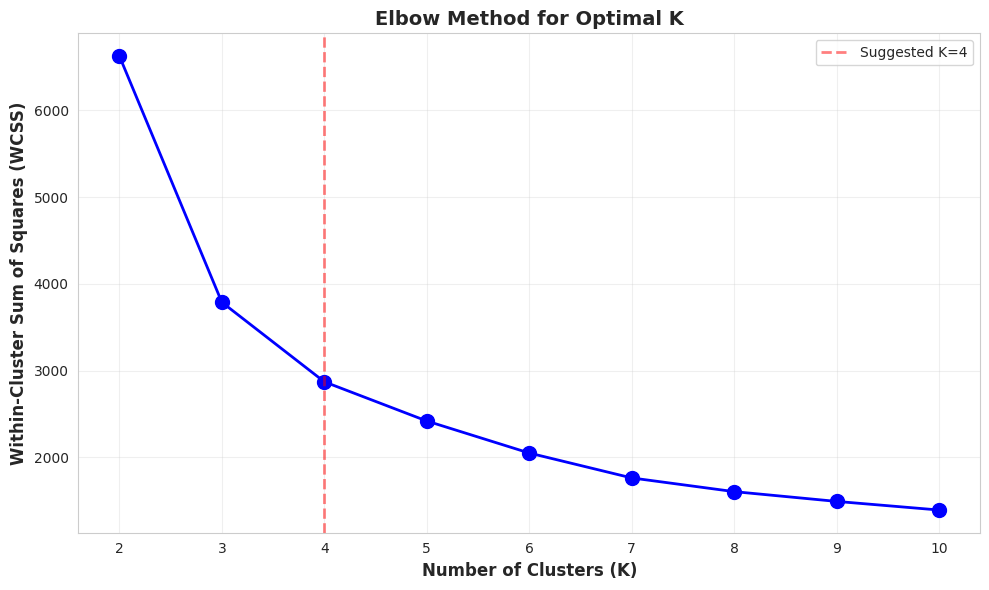


✓ Based on the Elbow Method, the optimal number of clusters appears to be around 3-4


In [8]:
# ============================================================================
# CELL 8: Determine Optimal Number of Clusters - Elbow Method
# ============================================================================
"""
Use the Elbow Method to find the optimal number of clusters by
analyzing the Within-Cluster Sum of Squares (WCSS)
"""

# Calculate WCSS for different numbers of clusters
wcss = []
K_range = range(2, 11)

print("Calculating WCSS for different K values...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)
    print(f"K={k}: WCSS={kmeans.inertia_:.2f}")

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, 'bo-', linewidth=2, markersize=10)
plt.xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12, fontweight='bold')
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)

# Highlight the elbow point (typically around 3-4 clusters)
plt.axvline(x=4, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Suggested K=4')
plt.legend()
plt.tight_layout()
plt.show()

print("\n✓ Based on the Elbow Method, the optimal number of clusters appears to be around 3-4")


Calculating Silhouette Scores for different K values...
K=2: Silhouette Score=0.4782
K=3: Silhouette Score=0.4785
K=4: Silhouette Score=0.4455
K=5: Silhouette Score=0.4178
K=6: Silhouette Score=0.3861
K=7: Silhouette Score=0.3789
K=8: Silhouette Score=0.3698
K=9: Silhouette Score=0.3515
K=10: Silhouette Score=0.3516


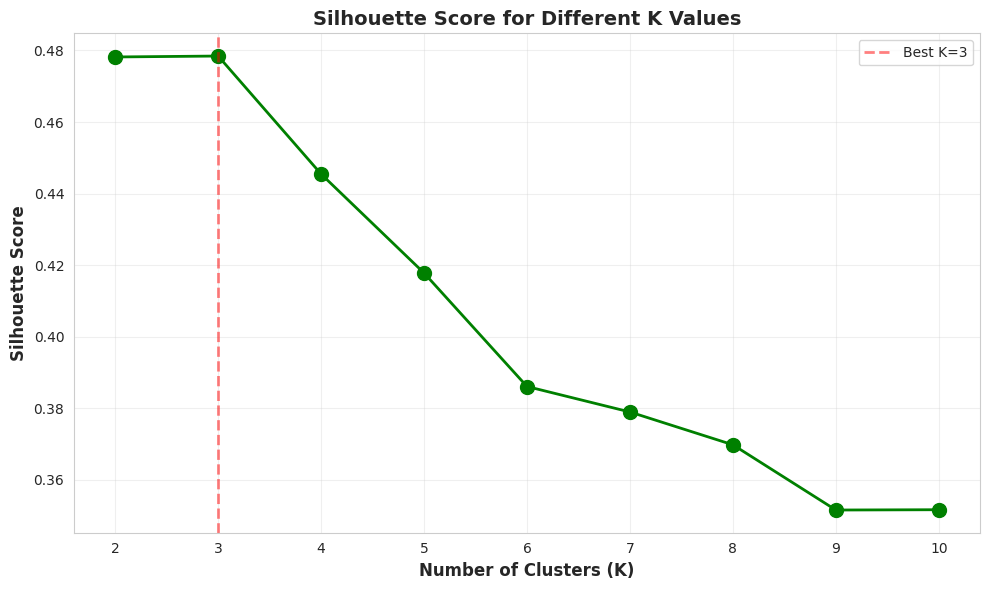


✓ Best Silhouette Score: K=3 with score=0.4785


In [9]:
# ============================================================================
# CELL 9: Determine Optimal Number of Clusters - Silhouette Score
# ============================================================================
"""
Use Silhouette Score to validate the optimal number of clusters
Higher silhouette score indicates better-defined clusters
"""

# Calculate Silhouette Score for different numbers of clusters
silhouette_scores = []

print("Calculating Silhouette Scores for different K values...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled_df)
    score = silhouette_score(rfm_scaled_df, labels)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score={score:.4f}")

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=10)
plt.xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=12, fontweight='bold')
plt.title('Silhouette Score for Different K Values', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)

# Highlight the best score
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
plt.axvline(x=best_k, color='red', linestyle='--', linewidth=2, alpha=0.5,
            label=f'Best K={best_k}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n✓ Best Silhouette Score: K={best_k} with score={max(silhouette_scores):.4f}")


In [10]:
# ============================================================================
# CELL 10: Apply K-Means Clustering
# ============================================================================
"""
Apply K-Means clustering with the optimal number of clusters (K=4)
"""

# Set optimal number of clusters
optimal_k = 4

# Initialize and fit K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
rfm_clean['Cluster'] = kmeans.fit_predict(rfm_scaled_df)

print(f"K-Means Clustering completed with K={optimal_k}")
print("\n" + "="*80)
print("Cluster Distribution:")
print(rfm_clean['Cluster'].value_counts().sort_index())
print("\n" + "="*80)

# Calculate clustering metrics
silhouette_avg = silhouette_score(rfm_scaled_df, rfm_clean['Cluster'])
davies_bouldin = davies_bouldin_score(rfm_scaled_df, rfm_clean['Cluster'])

print(f"Clustering Performance Metrics:")
print(f"- Silhouette Score: {silhouette_avg:.4f} (higher is better, range: -1 to 1)")
print(f"- Davies-Bouldin Index: {davies_bouldin:.4f} (lower is better)")
print(f"- Inertia (WCSS): {kmeans.inertia_:.2f}")

print("\n✓ K-Means clustering applied successfully!")


K-Means Clustering completed with K=4

Cluster Distribution:
Cluster
0     976
1     837
2    1895
3     349
Name: count, dtype: int64

Clustering Performance Metrics:
- Silhouette Score: 0.4455 (higher is better, range: -1 to 1)
- Davies-Bouldin Index: 0.8602 (lower is better)
- Inertia (WCSS): 2870.14

✓ K-Means clustering applied successfully!


In [19]:
# ============================================================================
# CELL 11: Analyze Cluster Characteristics
# ============================================================================
"""
Analyze and describe the characteristics of each customer segment
"""

# Calculate mean values for each cluster
cluster_summary = rfm_clean.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'min', 'max'],
    'Frequency': ['mean', 'median', 'min', 'max'],
    'Monetary': ['mean', 'median', 'min', 'max']
}).round(2)

print("Detailed Cluster Characteristics:")
print("="*100)
print(cluster_summary)
print("\n" + "="*100)

# Calculate cluster sizes
cluster_sizes = rfm_clean['Cluster'].value_counts().sort_index()
print("\nCluster Sizes:")
for cluster in range(optimal_k):
    size = cluster_sizes[cluster]
    percentage = (size / len(rfm_clean)) * 100

    print(f"\n   🔹 CLUSTER {cluster}: {size:,} customers ({percentage:.2f}%)")
    print(f"      - Average Recency: {cluster_means.loc[cluster, 'Recency']:.1f} days")
    print(f"      - Average Frequency: {cluster_means.loc[cluster, 'Frequency']:.1f} purchases")
    print(f"      - Average Monetary: ${cluster_means.loc[cluster, 'Monetary']:,.2f}")

    # Calculate total revenue contribution
    total_revenue = rfm_clean['Monetary'].sum()
    cluster_revenue = rfm_clean[rfm_clean['Cluster'] == cluster]['Monetary'].sum()
    revenue_percentage = (cluster_revenue / total_revenue) * 100
    print(f"      - Revenue Contribution: ${cluster_revenue:,.2f} ({revenue_percentage:.2f}%)")

print(f"\n💡 KEY INSIGHTS:")
print(f"   • Total Revenue: ${rfm_clean['Monetary'].sum():,.2f}")
print(f"   • Average Customer Value: ${rfm_clean['Monetary'].mean():,.2f}")
print(f"   • Most Valuable Segment: Cluster {cluster_means['Monetary'].idxmax()}")
print(f"   • Most Active Segment: Cluster {cluster_means['Frequency'].idxmax()}")
print(f"   • Most Recent Segment: Cluster {cluster_means['Recency'].idxmin()}")

print(f"\n✅ RECOMMENDATIONS:")
print(f"   1. Focus retention efforts on high-value segments")
print(f"   2. Create re-engagement campaigns for at-risk customers")
print(f"   3. Develop loyalty programs for frequent buyers")
print(f"   4. Personalize marketing messages based on segment characteristics")

print("\n" + "="*100)
print(" "*30 + "✓ CUSTOMER SEGMENTATION ANALYSIS COMPLETED!")
print("="*100)


Detailed Cluster Characteristics:
        Recency                  Frequency                Monetary           \
           mean median  min  max      mean median min max     mean   median   
Cluster                                                                       
0        255.66  252.5  152  374      1.42    1.0   1   7   392.49   302.52   
1         40.25   26.0    1  306      4.96    5.0   1  10  1821.96  1698.94   
2         54.45   46.0    1  163      1.95    2.0   1   6   532.75   462.66   
3         25.61   15.0    1  264      9.60    9.0   3  17  3390.77  3408.06   

                           
             min      max  
Cluster                    
0           3.75  2661.24  
1         201.12  4873.81  
2           6.20  2033.10  
3        1535.77  5155.66  


Cluster Sizes:

   🔹 CLUSTER 0: 976 customers (24.06%)
      - Average Recency: 255.7 days
      - Average Frequency: 1.4 purchases
      - Average Monetary: $392.49
      - Revenue Contribution: $383,070.19 (9.34%

More Insight deriving from the dataset, as it contain the cell 19:

In [20]:
# ============================================================================
# CELL 19: Additional Analysis - Customer Lifetime Value (CLV) Estimation
# ============================================================================
"""
Estimate Customer Lifetime Value for each segment
"""

print("CUSTOMER LIFETIME VALUE (CLV) ANALYSIS")
print("="*80)

# Simple CLV calculation: Average Purchase Value × Purchase Frequency × Customer Lifespan
# Assuming average customer lifespan of 3 years (36 months)

for cluster in range(optimal_k):
    cluster_data = rfm_clean[rfm_clean['Cluster'] == cluster]

    # Calculate metrics
    avg_purchase_value = cluster_data['Monetary'].mean() / cluster_data['Frequency'].mean()
    avg_purchase_frequency = cluster_data['Frequency'].mean()

    # Estimate customer lifespan based on recency (inverse relationship)
    avg_recency = cluster_data['Recency'].mean()
    estimated_lifespan_months = max(12, 36 - (avg_recency / 10))  # Basic estimation

    # Calculate CLV
    clv = avg_purchase_value * avg_purchase_frequency * (estimated_lifespan_months / 12)

    print(f"\n🔹 CLUSTER {cluster} ({cluster_labels[cluster]}):")
    print(f"   - Average Purchase Value: ${avg_purchase_value:.2f}")
    print(f"   - Average Purchase Frequency: {avg_purchase_frequency:.1f} times/year")
    print(f"   - Estimated Customer Lifespan: {estimated_lifespan_months:.1f} months")
    print(f"   - Estimated CLV: ${clv:.2f}")
    print(f"   - Total Segment Value: ${clv * len(cluster_data):,.2f}")

print("\n" + "="*80)
print("✓ CLV analysis completed!")

CUSTOMER LIFETIME VALUE (CLV) ANALYSIS

🔹 CLUSTER 0 (At-Risk/Churned (High Recency, Low Frequency, Low Monetary)):
   - Average Purchase Value: $275.79
   - Average Purchase Frequency: 1.4 times/year
   - Estimated Customer Lifespan: 12.0 months
   - Estimated CLV: $392.49
   - Total Segment Value: $383,070.19

🔹 CLUSTER 1 (Loyal Customers (Good Recency, Medium Frequency, Medium Monetary)):
   - Average Purchase Value: $367.20
   - Average Purchase Frequency: 5.0 times/year
   - Estimated Customer Lifespan: 32.0 months
   - Estimated CLV: $4854.79
   - Total Segment Value: $4,063,461.72

🔹 CLUSTER 2 (Potential Customers (Medium Recency, Low Frequency, Low Monetary)):
   - Average Purchase Value: $273.67
   - Average Purchase Frequency: 1.9 times/year
   - Estimated Customer Lifespan: 30.6 months
   - Estimated CLV: $1356.50
   - Total Segment Value: $2,570,575.73

🔹 CLUSTER 3 (Champions/VIP (Low Recency, High Frequency, High Monetary)):
   - Average Purchase Value: $353.35
   - Average

More Insight deriving from the dataset, as it contain the cell 20 (Extra Cell):

In [25]:
# ============================================================================
# CELL 20: Marketing Strategy Recommendations by Segment
# ============================================================================
"""
Provide actionable marketing strategy recommendations for each customer segment
"""

print("\n")
print("="*100)
print(" "*25 + "MARKETING STRATEGY RECOMMENDATIONS BY SEGMENT")
print("="*100)

for cluster in range(optimal_k):
    cluster_data = rfm_clean[rfm_clean['Cluster'] == cluster]
    size = len(cluster_data)
    percentage = (size / len(rfm_clean)) * 100

    r = cluster_means.loc[cluster, 'Recency']
    f = cluster_means.loc[cluster, 'Frequency']
    m = cluster_means.loc[cluster, 'Monetary']

    print(f"\n{'='*100}")
    print(f"CLUSTER {cluster}: {cluster_labels[cluster]}")
    print(f"Size: {size:,} customers ({percentage:.2f}%)")
    print(f"{'='*100}")

    print(f"\n📊 SEGMENT CHARACTERISTICS:")
    print(f"   • Recency: {r:.1f} days (Last purchase)")
    print(f"   • Frequency: {f:.1f} purchases")
    print(f"   • Monetary: ${m:,.2f} (Total spent)")

    print(f"\n🎯 MARKETING STRATEGIES:")

    if r < 50 and f > 50 and m > 2000:
        # VIP/Champions
        print(f"   1. 🌟 VIP Treatment:")
        print(f"      - Offer exclusive products and early access to new collections")
        print(f"      - Create a dedicated VIP customer service line")
        print(f"      - Send personalized thank-you notes and special gifts")
        print(f"\n   2. 💎 Loyalty Rewards:")
        print(f"      - Implement a premium tier loyalty program")
        print(f"      - Offer significant discounts on bulk purchases")
        print(f"      - Provide free shipping and premium packaging")
        print(f"\n   3. 📢 Referral Programs:")
        print(f"      - Incentivize referrals with substantial rewards")
        print(f"      - Turn them into brand ambassadors")
        print(f"\n   4. 📊 Engagement:")
        print(f"      - Request feedback on new products")
        print(f"      - Invite to exclusive events and product launches")

    elif r < 100 and f > 20 and m > 1000:
        # Loyal Customers
        print(f"   1. 🤝 Relationship Building:")
        print(f"      - Regular communication with personalized offers")
        print(f"      - Birthday and anniversary discounts")
        print(f"      - Create a sense of community")
        print(f"\n   2. 📈 Upselling Opportunities:")
        print(f"      - Recommend complementary products")
        print(f"      - Offer bundle deals and package discounts")
        print(f"      - Introduce premium product lines")
        print(f"\n   3. 🎁 Loyalty Programs:")
        print(f"      - Points-based rewards system")
        print(f"      - Tiered benefits to encourage higher spending")
        print(f"\n   4. 💬 Engagement:")
        print(f"      - Solicit reviews and testimonials")
        print(f"      - Feature them in customer success stories")

    elif r < 150 and f < 20:
        # Potential Customers
        print(f"   1. 🌱 Nurture and Educate:")
        print(f"      - Send educational content about product benefits")
        print(f"      - Share customer success stories and use cases")
        print(f"      - Provide how-to guides and tutorials")
        print(f"\n   2. 🎯 Targeted Promotions:")
        print(f"      - Time-limited discount offers")
        print(f"      - Free trial or sample products")
        print(f"      - First-time buyer incentives")
        print(f"\n   3. 📧 Email Marketing:")
        print(f"      - Welcome email series for new customers")
        print(f"      - Regular newsletters with valuable content")
        print(f"      - Personalized product recommendations")
        print(f"\n   4. 🔄 Frequency Building:")
        print(f"      - Subscription options for regular purchases")
        print(f"      - Reminder emails for replenishment")

    else:
        # At-Risk/Lost Customers
        print(f"   1. 🚨 Win-Back Campaigns:")
        print(f"      - 'We miss you' emails with special offers")
        print(f"      - Aggressive discounts to re-engage")
        print(f"      - Survey to understand why they left")
        print(f"\n   2. 🔄 Re-engagement Strategy:")
        print(f"      - Showcase new products or improvements")
        print(f"      - Highlight positive changes in service")
        print(f"      - Limited-time comeback offers")
        print(f"\n   3. 📞 Direct Outreach:")
        print(f"      - Personalized phone calls or emails")
        print(f"      - Address past issues or concerns")
        print(f"      - Offer special incentive to return")
        print(f"\n   4. 💡 Analysis:")
        print(f"      - Identify common reasons for churn")
        print(f"      - Implement preventive measures")
        print(f"      - Consider if re-activation is cost-effective")

    print(f"\n💰 BUDGET ALLOCATION:")
    total_revenue = rfm_clean['Monetary'].sum()
    cluster_revenue = cluster_data['Monetary'].sum()
    revenue_percentage = (cluster_revenue / total_revenue) * 100
    print(f"   • Revenue Contribution: {revenue_percentage:.2f}%")
    print(f"   • Recommended Marketing Budget: {revenue_percentage * 0.8:.2f}% of total budget")

print("\n" + "="*100)
print(" "*35 + "✓ STRATEGY RECOMMENDATIONS COMPLETED!")
print("="*100)

print("\n🎉 CONGRATULATIONS! Customer Segmentation Analysis is Complete!")
print("\nYou now have:")
print("   ✓ Identified customer segments using K-Means clustering")
print("   ✓ Analyzed RFM (Recency, Frequency, Monetary) patterns")
print("   ✓ Visualized clusters in multiple dimensions")
print("   ✓ Generated actionable marketing strategies")
print("   ✓ Exported results for further use")
print("\nNext Steps:")
print("   → Implement the recommended strategies for each segment")
print("   → Monitor segment movements over time")
print("   → A/B test different approaches within segments")
print("   → Refine segmentation based on business outcomes")

print("\n✓ All tasks completed successfully!")



                         MARKETING STRATEGY RECOMMENDATIONS BY SEGMENT

CLUSTER 0: At-Risk/Churned (High Recency, Low Frequency, Low Monetary)
Size: 976 customers (24.06%)

📊 SEGMENT CHARACTERISTICS:
   • Recency: 255.7 days (Last purchase)
   • Frequency: 1.4 purchases
   • Monetary: $392.49 (Total spent)

🎯 MARKETING STRATEGIES:
   1. 🚨 Win-Back Campaigns:
      - 'We miss you' emails with special offers
      - Aggressive discounts to re-engage
      - Survey to understand why they left

   2. 🔄 Re-engagement Strategy:
      - Showcase new products or improvements
      - Highlight positive changes in service
      - Limited-time comeback offers

   3. 📞 Direct Outreach:
      - Personalized phone calls or emails
      - Address past issues or concerns
      - Offer special incentive to return

   4. 💡 Analysis:
      - Identify common reasons for churn
      - Implement preventive measures
      - Consider if re-activation is cost-effective

💰 BUDGET ALLOCATION:
   • Revenue Cont

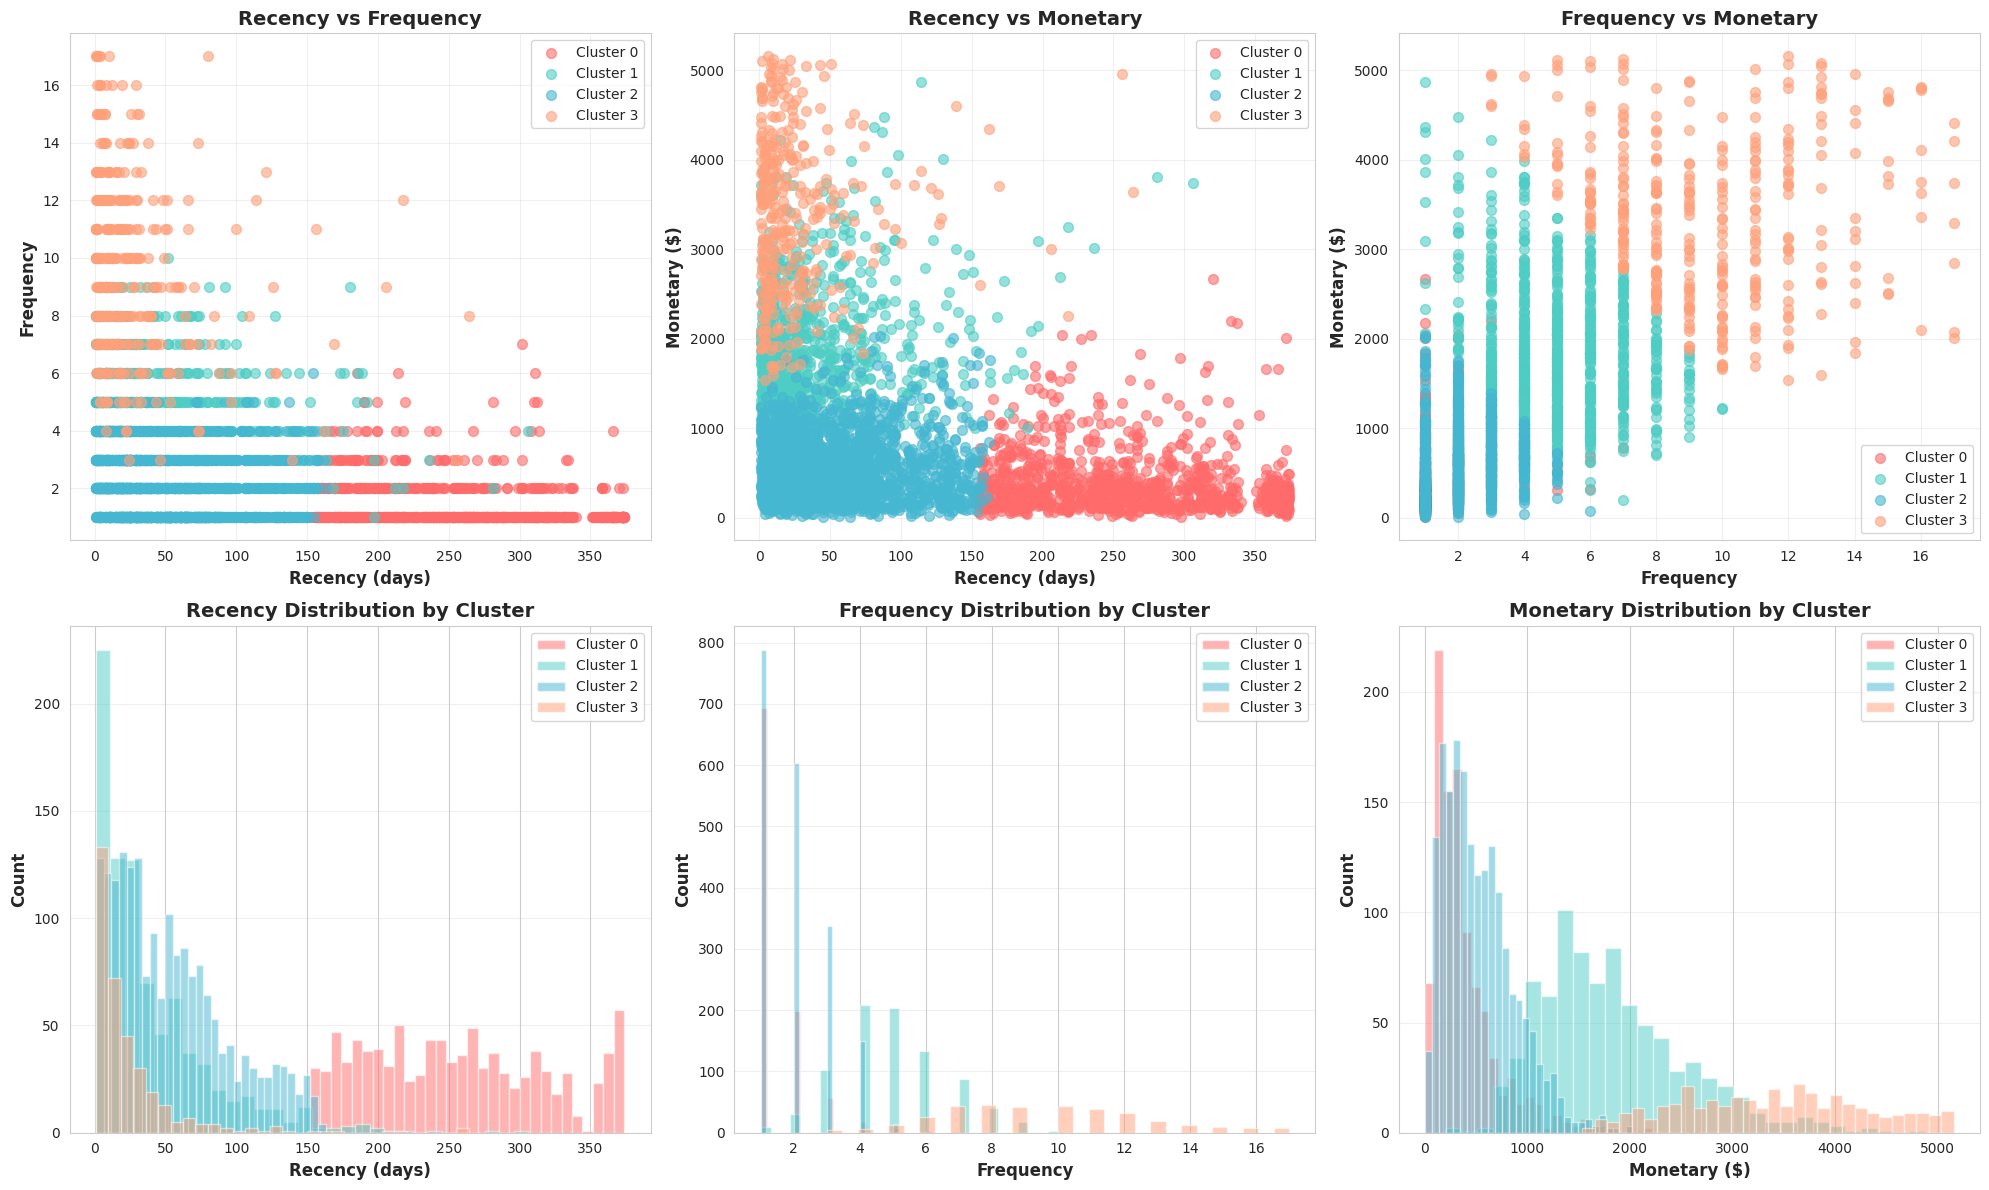

✓ 2D visualizations completed!


In [26]:
# ============================================================================
# CELL 12: Visualize Clusters - 2D Scatter Plots
# ============================================================================
"""
Visualize clusters using 2D scatter plots for different feature combinations
"""

# Define colors for clusters
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

# Create 2D scatter plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Recency vs Frequency
ax1 = axes[0, 0]
for cluster in range(optimal_k):
    cluster_data = rfm_clean[rfm_clean['Cluster'] == cluster]
    ax1.scatter(cluster_data['Recency'], cluster_data['Frequency'],
                c=colors[cluster], label=f'Cluster {cluster}', alpha=0.6, s=50)
ax1.set_xlabel('Recency (days)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Recency vs Frequency', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Recency vs Monetary
ax2 = axes[0, 1]
for cluster in range(optimal_k):
    cluster_data = rfm_clean[rfm_clean['Cluster'] == cluster]
    ax2.scatter(cluster_data['Recency'], cluster_data['Monetary'],
                c=colors[cluster], label=f'Cluster {cluster}', alpha=0.6, s=50)
ax2.set_xlabel('Recency (days)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Monetary ($)', fontsize=12, fontweight='bold')
ax2.set_title('Recency vs Monetary', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Frequency vs Monetary
ax3 = axes[0, 2]
for cluster in range(optimal_k):
    cluster_data = rfm_clean[rfm_clean['Cluster'] == cluster]
    ax3.scatter(cluster_data['Frequency'], cluster_data['Monetary'],
                c=colors[cluster], label=f'Cluster {cluster}', alpha=0.6, s=50)
ax3.set_xlabel('Frequency', fontsize=12, fontweight='bold')
ax3.set_ylabel('Monetary ($)', fontsize=12, fontweight='bold')
ax3.set_title('Frequency vs Monetary', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Recency Distribution by Cluster
ax4 = axes[1, 0]
for cluster in range(optimal_k):
    cluster_data = rfm_clean[rfm_clean['Cluster'] == cluster]
    ax4.hist(cluster_data['Recency'], bins=30, alpha=0.5, label=f'Cluster {cluster}',
             color=colors[cluster])
ax4.set_xlabel('Recency (days)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Count', fontsize=12, fontweight='bold')
ax4.set_title('Recency Distribution by Cluster', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Frequency Distribution by Cluster
ax5 = axes[1, 1]
for cluster in range(optimal_k):
    cluster_data = rfm_clean[rfm_clean['Cluster'] == cluster]
    ax5.hist(cluster_data['Frequency'], bins=30, alpha=0.5, label=f'Cluster {cluster}',
             color=colors[cluster])
ax5.set_xlabel('Frequency', fontsize=12, fontweight='bold')
ax5.set_ylabel('Count', fontsize=12, fontweight='bold')
ax5.set_title('Frequency Distribution by Cluster', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Monetary Distribution by Cluster
ax6 = axes[1, 2]
for cluster in range(optimal_k):
    cluster_data = rfm_clean[rfm_clean['Cluster'] == cluster]
    ax6.hist(cluster_data['Monetary'], bins=30, alpha=0.5, label=f'Cluster {cluster}',
             color=colors[cluster])
ax6.set_xlabel('Monetary ($)', fontsize=12, fontweight='bold')
ax6.set_ylabel('Count', fontsize=12, fontweight='bold')
ax6.set_title('Monetary Distribution by Cluster', fontsize=14, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ 2D visualizations completed!")


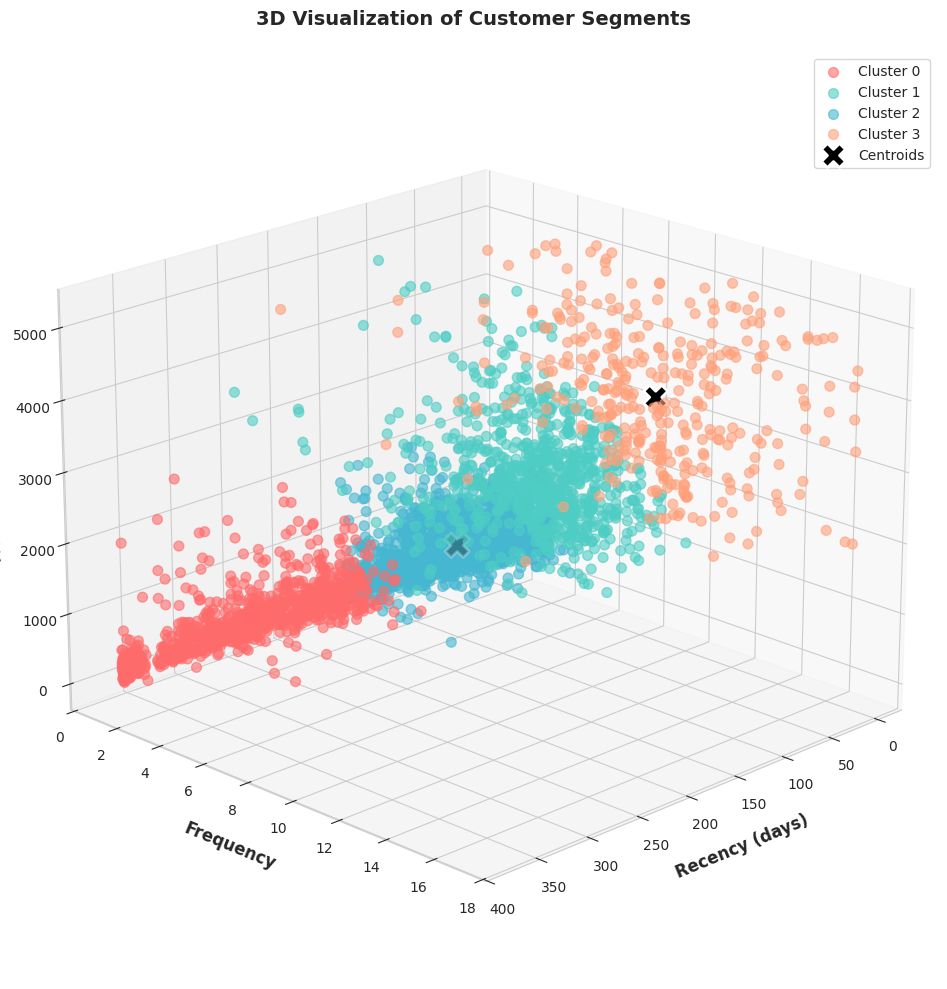

✓ 3D visualization completed!


In [27]:
# ============================================================================
# CELL 13: Visualize Clusters - 3D Scatter Plot
# ============================================================================
"""
Create a 3D scatter plot to visualize all three RFM dimensions simultaneously
"""

from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster
for cluster in range(optimal_k):
    cluster_data = rfm_clean[rfm_clean['Cluster'] == cluster]
    ax.scatter(cluster_data['Recency'],
               cluster_data['Frequency'],
               cluster_data['Monetary'],
               c=colors[cluster],
               label=f'Cluster {cluster}',
               alpha=0.6,
               s=50)

# Add cluster centers
centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
ax.scatter(centers_original[:, 0],
           centers_original[:, 1],
           centers_original[:, 2],
           c='black',
           marker='X',
           s=300,
           edgecolors='white',
           linewidths=2,
           label='Centroids')

# Labels and title
ax.set_xlabel('Recency (days)', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Monetary ($)', fontsize=12, fontweight='bold', labelpad=10)
ax.set_title('3D Visualization of Customer Segments', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=10)

# Adjust viewing angle
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print("✓ 3D visualization completed!")


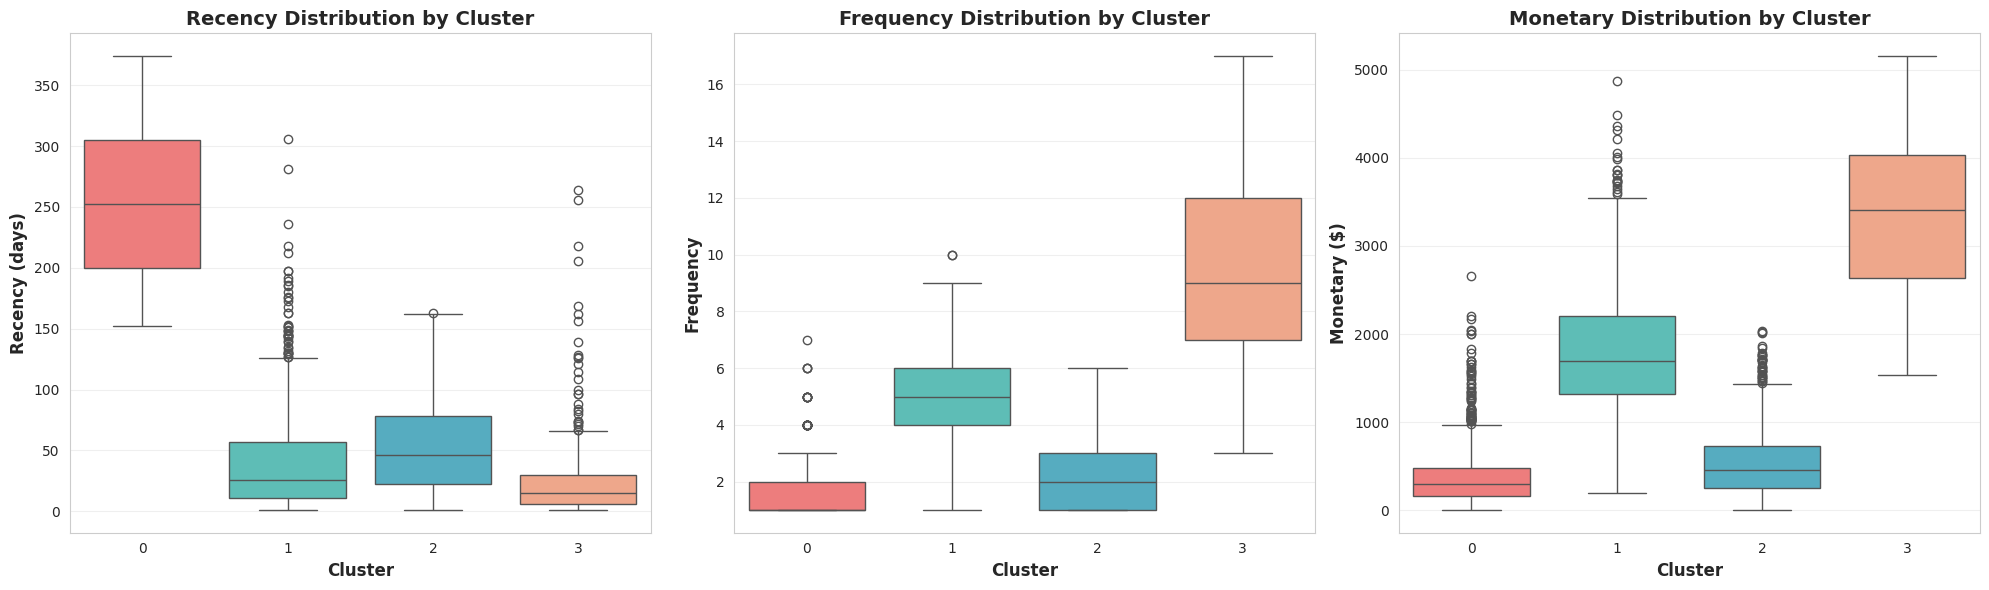

✓ Box plot visualizations completed!


In [28]:
# ============================================================================
# CELL 14: Box Plots for Cluster Comparison
# ============================================================================
"""
Create box plots to compare the distribution of RFM metrics across clusters
"""

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Box plot for Recency
sns.boxplot(data=rfm_clean, x='Cluster', y='Recency', palette=colors, ax=axes[0])
axes[0].set_title('Recency Distribution by Cluster', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Recency (days)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Box plot for Frequency
sns.boxplot(data=rfm_clean, x='Cluster', y='Frequency', palette=colors, ax=axes[1])
axes[1].set_title('Frequency Distribution by Cluster', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Box plot for Monetary
sns.boxplot(data=rfm_clean, x='Cluster', y='Monetary', palette=colors, ax=axes[2])
axes[2].set_title('Monetary Distribution by Cluster', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Monetary ($)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Box plot visualizations completed!")


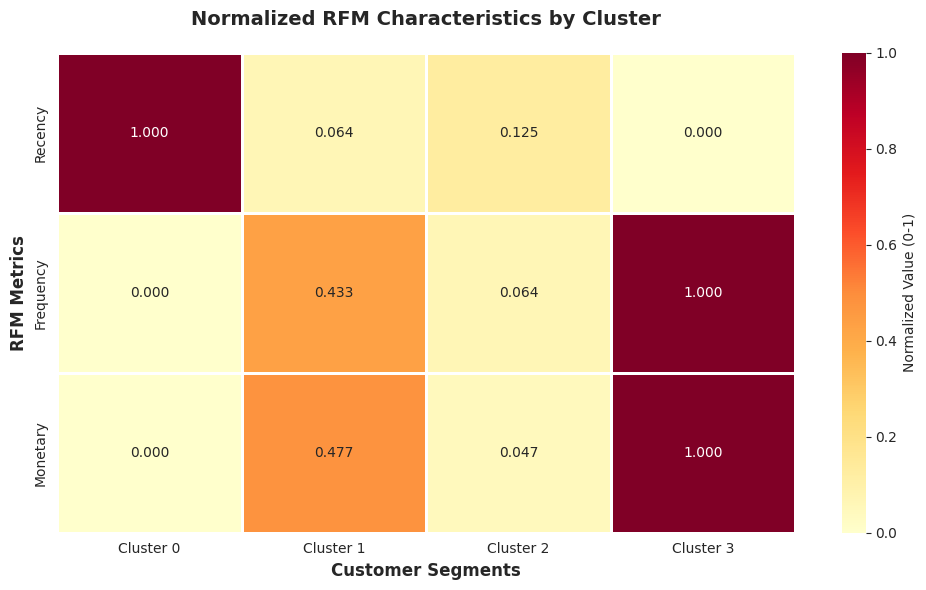

In [29]:
# ============================================================================
# CELL 15: Heatmap of Cluster Characteristics
# ============================================================================
"""
Create a heatmap to show the average RFM values for each cluster
"""

# Calculate normalized cluster means for heatmap
cluster_means_normalized = rfm_clean.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Normalize for better visualization
from sklearn.preprocessing import MinMaxScaler
scaler_viz = MinMaxScaler()
cluster_means_normalized_scaled = scaler_viz.fit_transform(cluster_means_normalized)
cluster_means_normalized_df = pd.DataFrame(
    cluster_means_normalized_scaled,
    columns=['Recency', 'Frequency', 'Monetary'],
    index=[f'Cluster {i}' for i in range(optimal_k)]
)

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means_normalized_df.T, annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Normalized Value (0-1)'}, linewidths=2, linecolor='white')
plt.title('Normalized RFM Characteristics by Cluster', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Customer Segments', fontsize=12, fontweight='bold')
plt.ylabel('RFM Metrics', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()






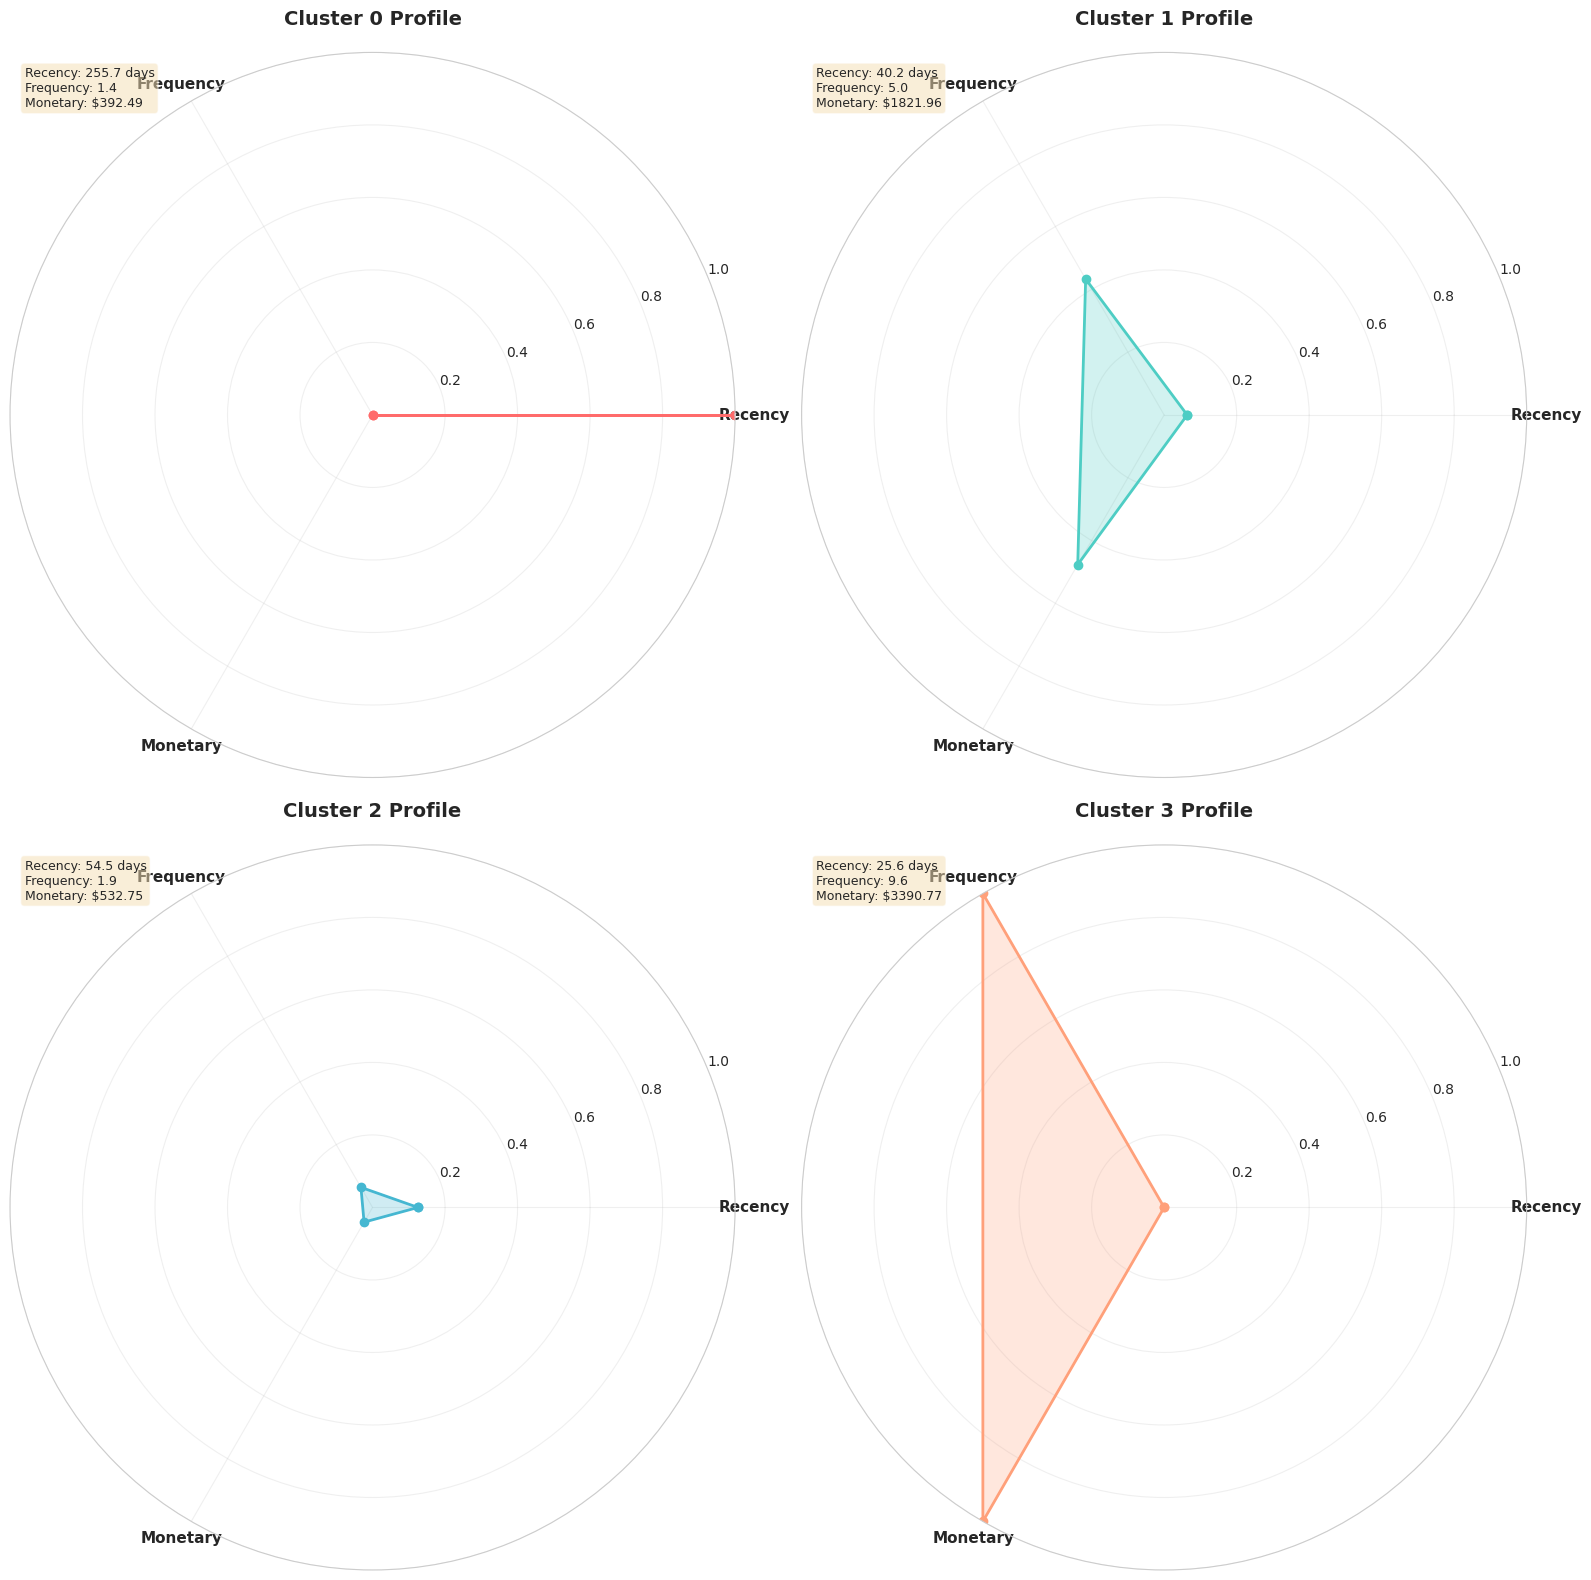

In [31]:
# ============================================================================
# CELL 16: Radar Chart for Cluster Comparison
# ============================================================================
"""
Create radar charts to compare cluster profiles across RFM dimensions
"""

import math

# Prepare data for radar chart
categories = ['Recency', 'Frequency', 'Monetary']
fig, axes = plt.subplots(2, 2, figsize=(16, 16), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

# Normalize cluster means for radar chart
cluster_means_radar = rfm_clean.groupby('Cluster')[categories].mean()
cluster_means_radar_normalized = (cluster_means_radar - cluster_means_radar.min()) / (cluster_means_radar.max() - cluster_means_radar.min())

# Number of variables
N = len(categories)
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]

# Plot radar chart for each cluster
for idx, cluster in enumerate(range(optimal_k)):
    ax = axes[idx]

    # Get values for this cluster
    values = cluster_means_radar_normalized.loc[cluster].values.tolist()
    values += values[:1]

    # Plot
    ax.plot(angles, values, 'o-', linewidth=2, color=colors[cluster], label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.25, color=colors[cluster])

    # Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_title(f'Cluster {cluster} Profile', fontsize=14, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3)

    # Add actual values as text
    actual_values = cluster_means_radar.loc[cluster]
    info_text = f"Recency: {actual_values['Recency']:.1f} days\n"
    info_text += f"Frequency: {actual_values['Frequency']:.1f}\n"
    info_text += f"Monetary: ${actual_values['Monetary']:.2f}"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()





In [33]:
# ============================================================================
# CELL 17: Final Summary Report
# ============================================================================
"""
Generate a comprehensive summary report of the customer segmentation analysis
"""

print("="*100)
print(" "*35 + "CUSTOMER SEGMENTATION ANALYSIS")
print(" "*38 + "FINAL SUMMARY REPORT")
print("="*100)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total Customers Analyzed: {len(rfm_clean):,}")
print(f"   • Number of Segments: {optimal_k}")
print(f"   • Date Range: {df['InvoiceDate'].min().strftime('%Y-%m-%d')} to {df['InvoiceDate'].max().strftime('%Y-%m-%d')}")

print(f"\n🎯 CLUSTERING PERFORMANCE:")
print(f"   • Silhouette Score: {silhouette_avg:.4f}")
print(f"   • Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"   • Total WCSS: {kmeans.inertia_:.2f}")

print(f"\n📈 SEGMENT BREAKDOWN:")
cluster_means = rfm_clean.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
cluster_sizes = rfm_clean['Cluster'].value_counts().sort_index()

for cluster in range(optimal_k):
    size = cluster_sizes[cluster]
    percentage = (size / len(rfm_clean)) * 100

    print(f"\n   🔹 CLUSTER {cluster}: {size:,} customers ({percentage:.2f}%)")
    print(f"      - Average Recency: {cluster_means.loc[cluster, 'Recency']:.1f} days")
    print(f"      - Average Frequency: {cluster_means.loc[cluster, 'Frequency']:.1f} purchases")
    print(f"      - Average Monetary: ${cluster_means.loc[cluster, 'Monetary']:,.2f}")

    # Calculate total revenue contribution
    total_revenue = rfm_clean['Monetary'].sum()
    cluster_revenue = rfm_clean[rfm_clean['Cluster'] == cluster]['Monetary'].sum()
    revenue_percentage = (cluster_revenue / total_revenue) * 100
    print(f"      - Revenue Contribution: ${cluster_revenue:,.2f} ({revenue_percentage:.2f}%)")

print(f"\n💡 KEY INSIGHTS:")
print(f"   • Total Revenue: ${rfm_clean['Monetary'].sum():,.2f}")
print(f"   • Average Customer Value: ${rfm_clean['Monetary'].mean():,.2f}")
print(f"   • Most Valuable Segment: Cluster {cluster_means['Monetary'].idxmax()}")
print(f"   • Most Active Segment: Cluster {cluster_means['Frequency'].idxmax()}")
print(f"   • Most Recent Segment: Cluster {cluster_means['Recency'].idxmin()}")

print(f"\n✅ RECOMMENDATIONS:")
print(f"   1. Focus retention efforts on high-value segments")
print(f"   2. Create re-engagement campaigns for at-risk customers")
print(f"   3. Develop loyalty programs for frequent buyers")
print(f"   4. Personalize marketing messages based on segment characteristics")

print("\n" + "="*100)
print(" "*30 + "✓ CUSTOMER SEGMENTATION ANALYSIS COMPLETED!")
print("="*100)

                                   CUSTOMER SEGMENTATION ANALYSIS
                                      FINAL SUMMARY REPORT

📊 DATASET OVERVIEW:
   • Total Customers Analyzed: 4,057
   • Number of Segments: 4
   • Date Range: 2010-12-01 to 2011-12-09

🎯 CLUSTERING PERFORMANCE:
   • Silhouette Score: 0.4455
   • Davies-Bouldin Index: 0.8602
   • Total WCSS: 2870.14

📈 SEGMENT BREAKDOWN:

   🔹 CLUSTER 0: 976 customers (24.06%)
      - Average Recency: 255.7 days
      - Average Frequency: 1.4 purchases
      - Average Monetary: $392.49
      - Revenue Contribution: $383,070.19 (9.34%)

   🔹 CLUSTER 1: 837 customers (20.63%)
      - Average Recency: 40.2 days
      - Average Frequency: 5.0 purchases
      - Average Monetary: $1,821.96
      - Revenue Contribution: $1,524,976.72 (37.19%)

   🔹 CLUSTER 2: 1,895 customers (46.71%)
      - Average Recency: 54.5 days
      - Average Frequency: 1.9 purchases
      - Average Monetary: $532.75
      - Revenue Contribution: $1,009,566.19 (24.62%)